In [1]:
from elasticsearch import Elasticsearch
from image_match.elasticsearch_driver import SignatureES
from glob import glob
from tools import get_data_file
import os
import matplotlib.pyplot as plt
import shutil
from PIL import Image

In [2]:
es = Elasticsearch([{'host': 'localhost', 'port': 9200}])
ses = SignatureES(es,index='salsavalentina_ix')

Expect to have images in `data/raw/images`

Expect to have the folder `data/raw/duplicates`

Expect to have an Elasticsearch instance running on the port 9200

In [3]:
image_extension = set(['.jpg', '.jpeg', '.png'])

In [4]:
# Get the size since I want bigger images first.
images = []
non_images = list()
for image_file in glob(get_data_file('raw', 'images/*')):
    image_name = os.path.basename(image_file)
    name, extension = os.path.splitext(image_name)
    if extension.lower() in image_extension:
        with Image.open(image_file) as img:
            width, height = img.size
            images.append((image_file, width * height))
            ses.add_image(image_file)
    else:
        non_images.append(image_file)

In [5]:
sorted_images = sorted(images, key=lambda i: i[1], reverse=True)
len(sorted_images)

1349

In [6]:
# Delete non-images:
for non_image in non_images:
    os.remove(non_image)

In [7]:
def split_names(path):
    image_name = os.path.basename(path)
    name, extension = os.path.splitext(image_name)
    return image_name, name, extension

def show_images(query, results, imgsize=15):
    _, name, _ = split_names(query)
    result_paths = [(query, -1)] + [(r['path'], r['dist']) for r in results]
    f, ax = plt.subplots(1,len(result_paths), figsize=(imgsize, imgsize * len(result_paths)))
    for i, result in enumerate(result_paths):
        path, dist = result
        _, name, _ = split_names(path)
        img = plt.imread(path)
        ax[i].set_title(f'{name[:15]} - {dist:0.2f}')
        ax[i].imshow(img)
        
def query_images(query, threshold=1.0):
    results = ses.search_image(query)
    filtered = []
    for r in results:
        if r['path'] == query:
            continue
        if r['dist'] > threshold:
            continue
        filtered.append(r)
        
    return sorted(filtered, key=lambda r: r['dist'])

## Matches examination

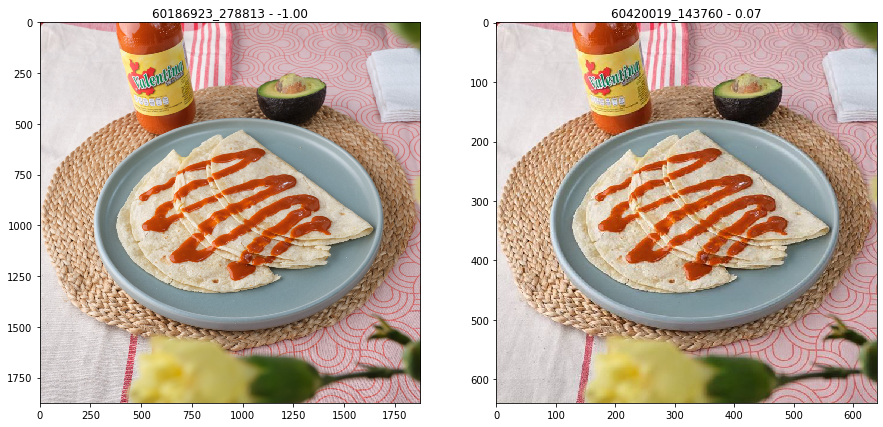

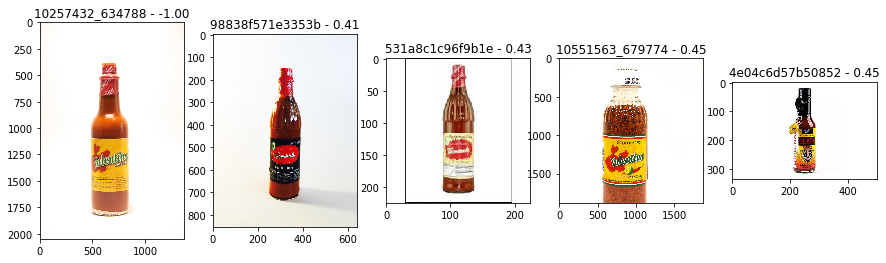

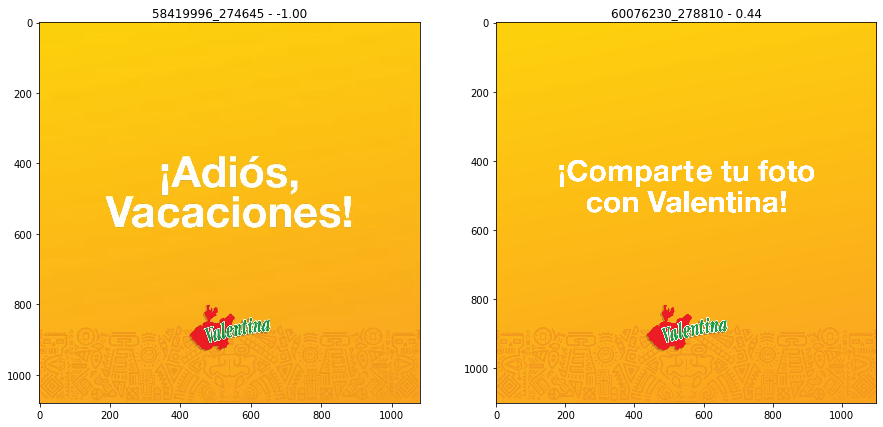

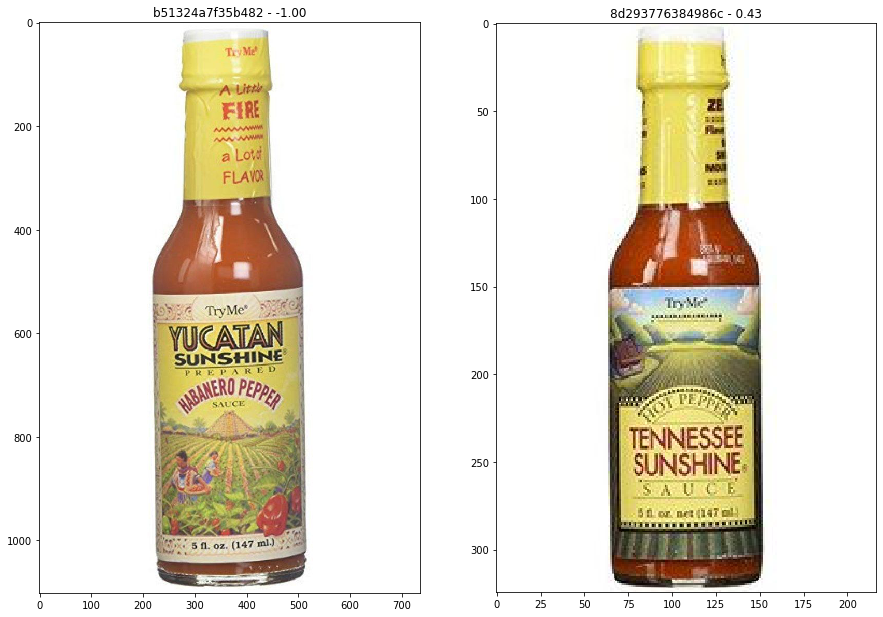

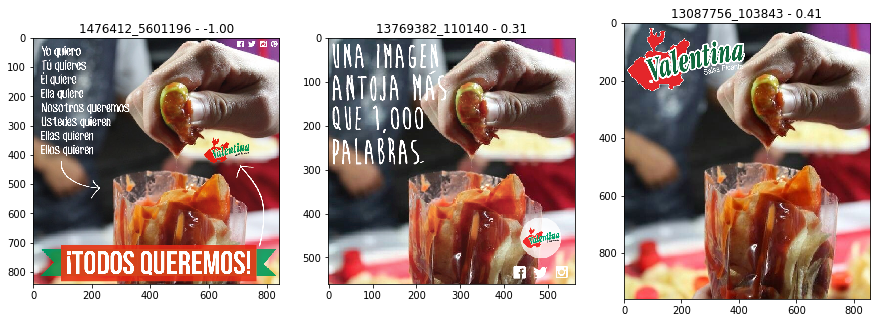

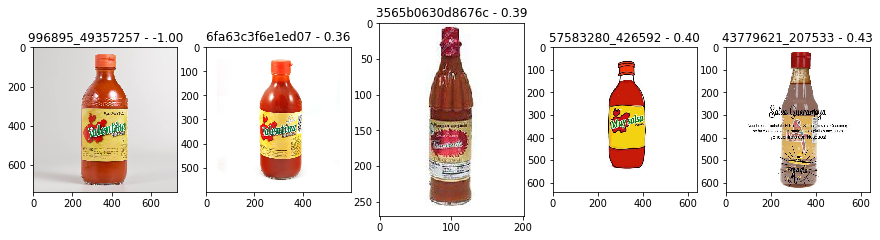

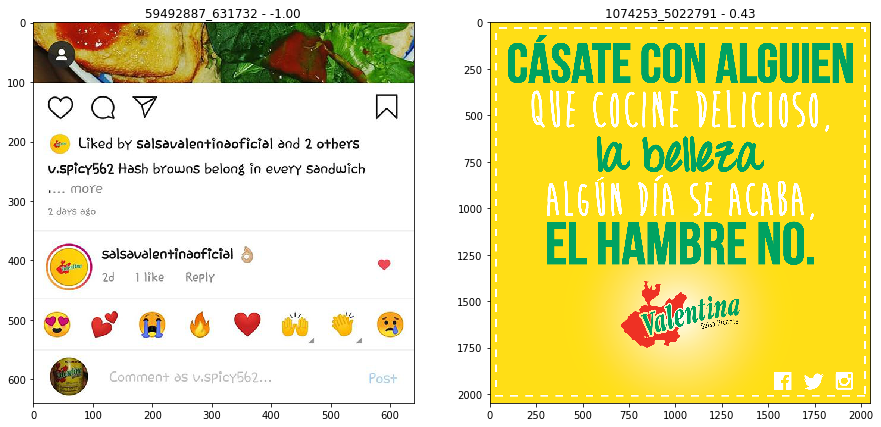

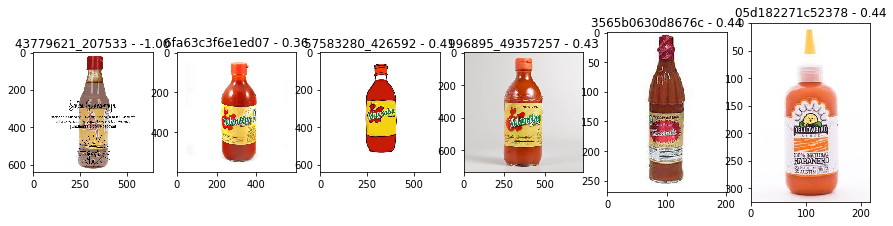

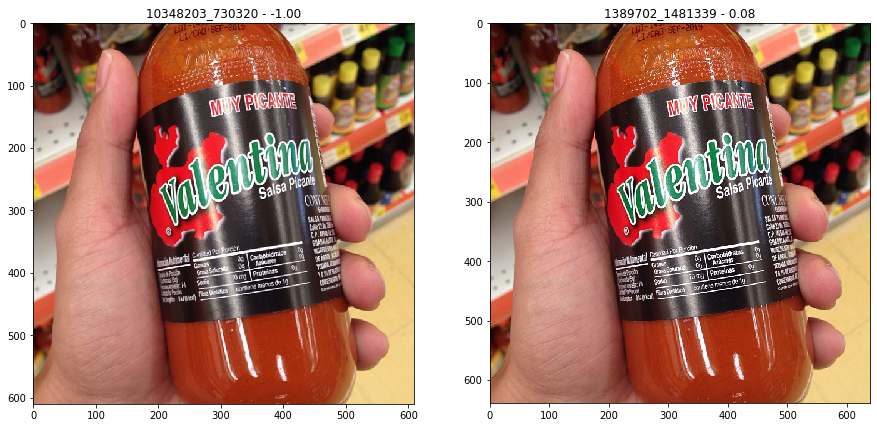

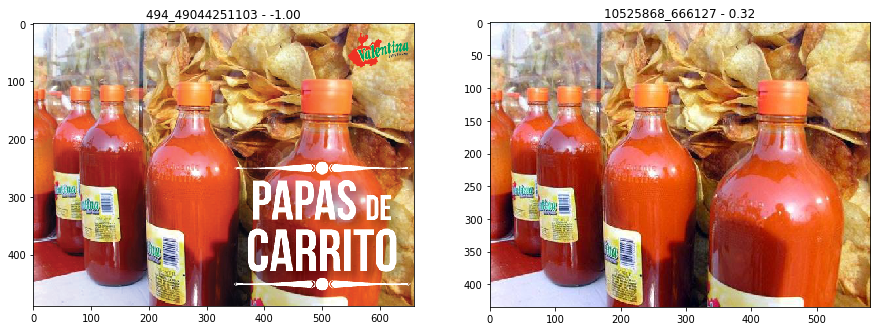

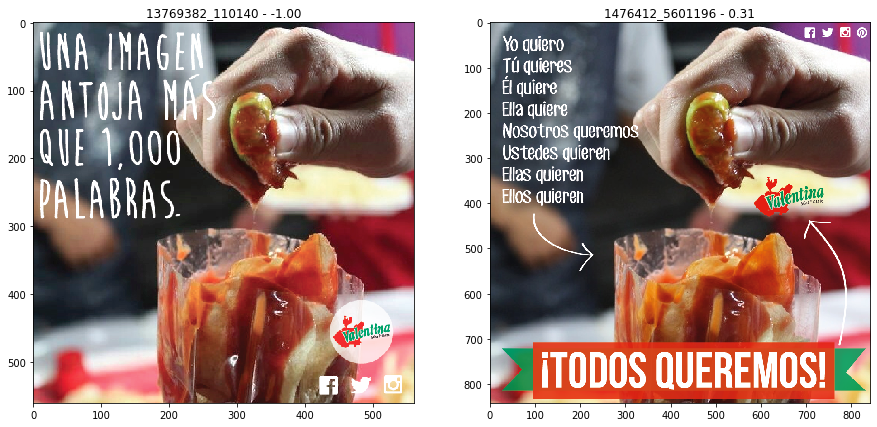

In [9]:
count = 10
for image_file, size in sorted_images[10::4]:
    query = image_file
    results = query_images(query)
    if results:
        show_images(query, results)
    
        if count == 0:
            break
        count -= 1

## Actual filtering

In [10]:
good_images = set()
duplicates = set()

for image_file, size in images:
    image_name, _, _ = split_names(image_file)
    if image_name in duplicates:
        continue
    if image_name in good_images:
        continue
        
    good_images.add(image_name)
    
    results = query_images(image_file, 0.4)
    for res in results:
        dup_name, _, _ = split_names(res['path'])
        duplicates.add(dup_name)   

/Users/antonioferegrino/.local/share/virtualenvs/salsa-valentina-jMmJ4Jum/lib/python3.6/site-packages/image_match/signature_database_base.py:469: RuntimeWarning: invalid value encountered in true_divide
  finvec = topvec / (norm1 + norm2)


In [11]:
len(duplicates), len(good_images)

(28, 1321)

In [12]:
destination_folder = get_data_file('raw', 'duplicated')
origin_folder = get_data_file('raw', 'images')

if not os.path.exists(destination_folder):
    os.mkdir(destination_folder)

for duplicate_file in duplicates:
    image_name, _, _ = split_names(duplicate_file)
    destination_file = os.path.join(destination_folder, image_name)
    orign_file = os.path.join(origin_folder, image_name)
    shutil.move(orign_file, destination_file)